In [ ]:
import os
from functools import reduce
import pandas as pd
import networkx as nx


import matplotlib.pyplot as plt

In [ ]:
# Create graph where nodes are countries and edges are interconnectors
# Each edge represent the total flow between two countries

G = nx.DiGraph()

# From Belgium
G.add_edge("BE", "DE")
G.add_edge("BE", "FR")
G.add_edge("BE", "LU")
G.add_edge("BE", "NL")
G.add_edge("BE", "UK")
# To Belgium
G.add_edge("DE", "BE")
G.add_edge("FR", "BE")
G.add_edge("LU", "BE")
G.add_edge("NL", "BE")
G.add_edge("UK", "BE")
# From Denmark
G.add_edge("DK", "DE")
G.add_edge("DK", "NL")
G.add_edge("DK", "NO")
G.add_edge("DK", "SE")
G.add_edge("DK", "UK")
# To Denmark
G.add_edge("DE", "DK")
G.add_edge("NL", "DK")
G.add_edge("NO", "DK")
G.add_edge("SE", "DK")
G.add_edge("UK", "DK")
# From Germany
G.add_edge("DE", "AT")
G.add_edge("DE", "BE")
G.add_edge("DE", "CH")
G.add_edge("DE", "CZ")
G.add_edge("DE", "DK")
G.add_edge("DE", "FR")
G.add_edge("DE", "LU")
G.add_edge("DE", "NL")
G.add_edge("DE", "NO")
G.add_edge("DE", "PL")
G.add_edge("DE", "SE")
# To Germany
G.add_edge("AT", "DE")
G.add_edge("BE", "DE")
G.add_edge("CH", "DE")
G.add_edge("CZ", "DE")
G.add_edge("DK", "DE")
G.add_edge("FR", "DE")
G.add_edge("LU", "DE")
G.add_edge("NL", "DE")
G.add_edge("NO", "DE")
G.add_edge("PL", "DE")
G.add_edge("SE", "DE")
# From France
G.add_edge("FR", "BE")
G.add_edge("FR", "CH")
G.add_edge("FR", "DE")
G.add_edge("FR", "ES")
G.add_edge("FR", "IT")
G.add_edge("FR", "UK")
# To France
G.add_edge("BE", "FR")
G.add_edge("CH", "FR")
G.add_edge("DE", "FR")
G.add_edge("ES", "FR")
G.add_edge("IT", "FR")
G.add_edge("UK", "FR")
# From Netherlands
G.add_edge("NL", "BE")
G.add_edge("NL", "DE")
G.add_edge("NL", "DK")
G.add_edge("NL", "NO")
G.add_edge("NL", "UK")
# To Netherlands
G.add_edge("BE", "NL")
G.add_edge("DE", "NL")
G.add_edge("DK", "NL")
G.add_edge("NO", "NL")
G.add_edge("UK", "NL")
# From Norway
G.add_edge("NO", "DE")
G.add_edge("NO", "DK")
G.add_edge("NO", "FI")
G.add_edge("NO", "NL")
G.add_edge("NO", "SE")
G.add_edge("NO", "UK")
# To Norway
G.add_edge("DE", "NO")
G.add_edge("DK", "NO")
G.add_edge("FI", "NO")
G.add_edge("NL", "NO")
G.add_edge("SE", "NO")
G.add_edge("UK", "NO")
# From United Kingdom
G.add_edge("UK", "BE")
G.add_edge("UK", "DK")
G.add_edge("UK", "FR")
G.add_edge("UK", "IE")
G.add_edge("UK", "NL")
G.add_edge("UK", "NO")
# To United Kingdom
G.add_edge("BE", "UK")
G.add_edge("DK", "UK")
G.add_edge("FR", "UK")
G.add_edge("IE", "UK")
G.add_edge("NL", "UK")
G.add_edge("NO", "UK")

print(G.nodes())
# Print all edges both ways
print(G.edges())

In [ ]:
dfs = {}
for edge in G.edges():
    cty_from = edge[0]
    cty_to = edge[1]
    filename = "data/flow/" + cty_from + "_" + cty_to + "_202304010000-202311010000.csv"
    dfs[f"{cty_from}->{cty_to}"] = pd.read_csv(filename, index_col=0)

In [ ]:
# Combine all dataframes into one, where individual dataframes have column 'quantity'
df = pd.concat(dfs, axis=1)
# Remove the multiindex column names
df.columns = df.columns.droplevel(1)
# Set index to datetimeindex
df.index = pd.to_datetime(df.index)

In [ ]:
# Downsample from 15 minutes to 1 hour, if NaNs are present, fill with NaNs
df = df.resample("1H").mean()

In [ ]:
df.to_csv("data/flow/combined.csv")

In [ ]:
for edge, df in dfs.items():
    u, v = edge.split("->")
    G[u][v]["flow"] = round(df["quantity"].mean(), 2)

In [ ]:
# Draw graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="skyblue",
    edge_cmap=plt.cm.Blues,
    arrows=True,
)
edge_labels = nx.get_edge_attributes(G, "flow")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [ ]:
# Print ranked betweenness centrality and closeness centrality
print("Betweenness centrality")
print(sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True))
print("Closeness centrality")
print(sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# Node Features:
# - Actual generation by fuel type
# - Local demand
# - Local day-ahead price

# Edge Features:
# - Flow between nodes

In [93]:
dap_df = pd.DataFrame()
for node in G.nodes():
    # Grab all files with filename containing node name as the first two characters
    filenames = [f for f in os.listdir("data/dap") if f.startswith(node)]
    # Special case for Luxembourg where the filenames start with DE-AT-LU and BZN|DE-LU
    if node == "LU":
        filenames = [
            f
            for f in os.listdir("data/dap")
            if f.startswith("DE-AT-LU") or f.startswith("DE-LU")
        ]
    if node == "UK":
        filenames = [
            f
            for f in os.listdir("data/dap")
            if f.startswith("GB") or f.startswith("IE(SEM)")
        ]
    # Read all files and merge into one dataframe by index, and take average of all prices
    dfs = [pd.read_csv("data/dap/" + filename, index_col=0) for filename in filenames]
    for df in dfs:
        # Duplicates are probably caused by extra price data at EXAA for Austria
        # these prices are at 15 minute intervals
        # We keep the 1 hour interval prices which appear after the 15 minute prices
        # in the dataframe
        df = df[~df.index.duplicated(keep="last")]
        df.index = pd.to_datetime(df.index)
        dap_df[node] = df["price.amount"]

In [94]:
dap_df

,BE,DE,FR,LU,NL,UK,DK,NO,SE,AT,CH,CZ,PL,ES,IT,FI,IE
2023-03-31 22:00:00+00:00,82.19,82.19,82.19,82.19,82.19,130.00,39.58,84.91,39.58,82.19,96.70,82.19,125.37,82.19,130.48,39.58,130.00
2023-03-31 23:00:00+00:00,63.90,63.90,63.90,63.90,63.90,118.87,36.62,81.74,36.62,63.90,98.34,63.90,125.39,63.90,124.41,36.62,118.87
2023-04-01 00:00:00+00:00,53.84,53.84,53.84,53.84,53.84,115.84,34.96,81.14,34.96,53.84,99.39,53.84,125.40,50.00,123.19,34.96,115.84
2023-04-01 01:00:00+00:00,44.39,38.83,42.50,38.83,53.99,115.60,35.52,81.27,35.52,40.05,99.55,39.41,125.70,42.50,104.50,35.52,115.60
2023-04-01 02:00:00+00:00,41.22,36.05,39.45,36.05,55.01,112.54,35.19,82.24,35.19,37.39,98.26,36.71,125.66,39.45,99.00,35.19,112.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01 18:00:00+00:00,71.80,66.57,71.90,66.57,74.97,217.80,64.97,64.97,64.97,79.44,76.05,67.22,77.15,4.30,200.10,19.69,217.80
2023-11-01 19:00:00+00:00,57.48,53.15,56.59,53.15,61.18,204.01,53.15,56.92,53.15,56.91,67.95,53.58,53.15,7.87,189.00,19.57,204.01
2023-11-01 20:00:00+00:00,40.15,39.51,40.87,39.51,39.83,193.00,31.68,52.66,31.68,43.90,61.99,36.61,62.85,11.56,143.74,20.05,193.00
2023-11-01 21:00:00+00:00,40.77,34.17,38.83,34.17,48.40,145.00,19.11,50.00,19.11,36.87,61.94,34.26,38.20,4.55,130.78,19.11,145.00


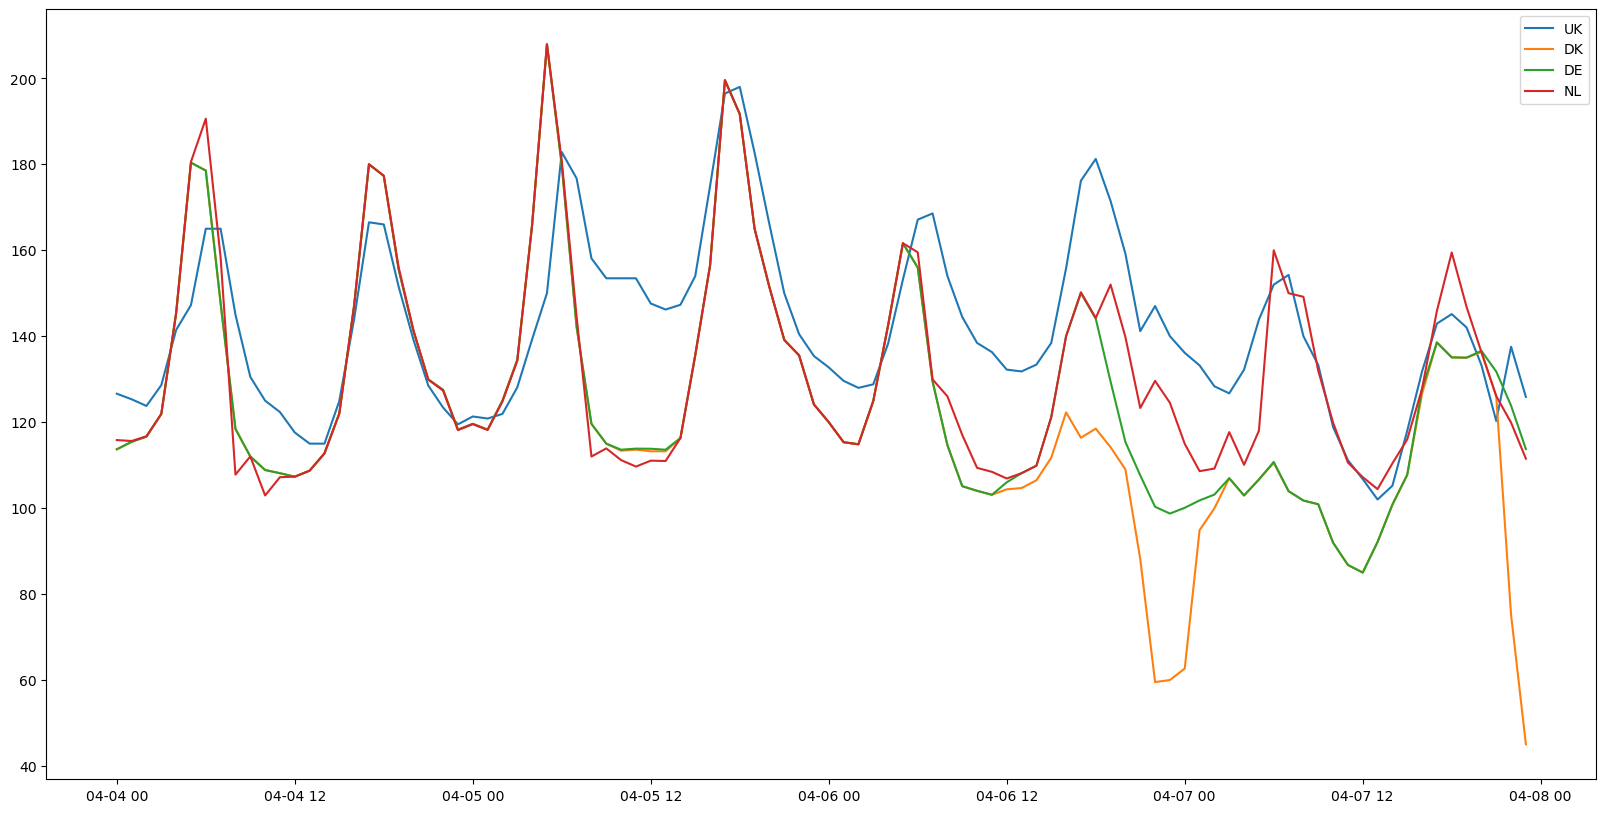

In [105]:
plt.figure(figsize=(20, 10))
plt.plot(
    dap_df['2023-04-04':'2023-04-07'][
        [
            "UK",
            "DK",
            "DE",
            "NL",
        ]
    ]
)
plt.legend(
    [
        "UK",
        "DK",
        "DE",
        "NL",
    ]
)
plt.show()